In [73]:
# @author: Sreenivas Bhattiprolu

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime


In [74]:
df = pd.read_csv('AAPL.csv')
print(df.head()) #7 columns, including the Date. 


                        date    close     high     low    open    volume
0  2015-05-27 00:00:00+00:00  132.045  132.260  130.05  130.34  45833246
1  2015-05-28 00:00:00+00:00  131.780  131.950  131.10  131.86  30733309
2  2015-05-29 00:00:00+00:00  130.280  131.450  129.90  131.23  50884452
3  2015-06-01 00:00:00+00:00  130.535  131.390  130.05  131.20  32112797
4  2015-06-02 00:00:00+00:00  129.960  130.655  129.32  129.86  33667627


In [75]:
df.tail()

,date,close,high,low,open,volume
1253,2020-05-18 00:00:00+00:00,314.96,316.50,310.3241,313.17,33843125
1254,2020-05-19 00:00:00+00:00,313.14,318.52,313.0100,315.03,25432385
1255,2020-05-20 00:00:00+00:00,319.23,319.52,316.2000,316.68,27876215
1256,2020-05-21 00:00:00+00:00,316.85,320.89,315.8700,318.66,25672211
1257,2020-05-22 00:00:00+00:00,318.89,319.23,315.3500,315.77,20450754


In [76]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['date'])
print(train_dates.tail(15)) #Check last few dates. 


1243   2020-05-04 00:00:00+00:00
1244   2020-05-05 00:00:00+00:00
1245   2020-05-06 00:00:00+00:00
1246   2020-05-07 00:00:00+00:00
1247   2020-05-08 00:00:00+00:00
1248   2020-05-11 00:00:00+00:00
1249   2020-05-12 00:00:00+00:00
1250   2020-05-13 00:00:00+00:00
1251   2020-05-14 00:00:00+00:00
1252   2020-05-15 00:00:00+00:00
1253   2020-05-18 00:00:00+00:00
1254   2020-05-19 00:00:00+00:00
1255   2020-05-20 00:00:00+00:00
1256   2020-05-21 00:00:00+00:00
1257   2020-05-22 00:00:00+00:00
Name: date, dtype: datetime64[ns, UTC]


In [77]:

#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']


['close', 'high', 'low', 'open', 'volume']


In [78]:
print(list(df))

['date', 'close', 'high', 'low', 'open', 'volume']


In [79]:

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()


In [80]:
df_for_training.head()

,close,high,low,open,volume
0,132.045,132.260,130.05,130.34,45833246.0
1,131.780,131.950,131.10,131.86,30733309.0
2,130.280,131.450,129.90,131.23,50884452.0
3,130.535,131.390,130.05,131.20,32112797.0
4,129.960,130.655,129.32,129.86,33667627.0


In [81]:

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)



In [82]:
df_for_training_scaled

array([[-0.62783971, -0.64321905, -0.64285248, -0.65750369,  0.62654466],
       [-0.63250289, -0.64861249, -0.62409729, -0.63064392, -0.24708587],
       [-0.65889824, -0.65731158, -0.64553179, -0.64177658,  0.9187901 ],
       ...,
       [ 2.66603573,  2.6147645 ,  2.68217447,  2.63529253, -0.41238752],
       [ 2.62415511,  2.63860001,  2.67627998,  2.67028092, -0.53990363],
       [ 2.66005279,  2.60971903,  2.6669917 ,  2.61921201, -0.84199921]])

In [83]:
scaler2 = StandardScaler()
check = scaler2.fit_transform(df_for_training)
check

array([[-0.62783971, -0.64321905, -0.64285248, -0.65750369,  0.62654466],
       [-0.63250289, -0.64861249, -0.62409729, -0.63064392, -0.24708587],
       [-0.65889824, -0.65731158, -0.64553179, -0.64177658,  0.9187901 ],
       ...,
       [ 2.66603573,  2.6147645 ,  2.68217447,  2.63529253, -0.41238752],
       [ 2.62415511,  2.63860001,  2.67627998,  2.67028092, -0.53990363],
       [ 2.66005279,  2.60971903,  2.6669917 ,  2.61921201, -0.84199921]])

In [84]:

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)


In [85]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1244, 14, 5).
trainY shape == (1244, 1).


In [86]:

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


trainX shape == (1244, 14, 5).
trainY shape == (1244, 1).
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [87]:

# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/50
70/70 [==============================] - 12s 41ms/step - loss: 0.0928 - val_loss: 0.7233
Epoch 2/50
70/70 [==============================] - 1s 19ms/step - loss: 0.0257 - val_loss: 0.1135
Epoch 3/50
70/70 [==============================] - 1s 19ms/step - loss: 0.0261 - val_loss: 0.1912
Epoch 4/50
70/70 [==============================] - 1s 18ms/step - loss: 0.0228 - val_loss: 0.2211
Epoch 5/50
70/70 [==============================] - 1s 19ms/step - loss: 0.0224 - val_loss: 0.1019
Epoch 6/50
70/70 [==============================] - 2s 22ms/step - loss: 0.0242 - val_loss: 0.0740
Epoch 7/50
70/70 [==============================] - 1s 19ms/step - loss: 0.0200 - val_loss: 0.4290
Epoch 8/50
70/70 [==============================] - 1s 19ms/step - loss: 0.0200 - val_loss: 0.0984
Epoch 9/50
70/70 [==============================] - 1s 19ms/step - loss: 0.0209 - val_loss: 0.1687
Epoch 10/50
70/70 [==============================] - 1s 18ms/step - loss: 0.0221 - val_loss: 0.0695
Epoch 11

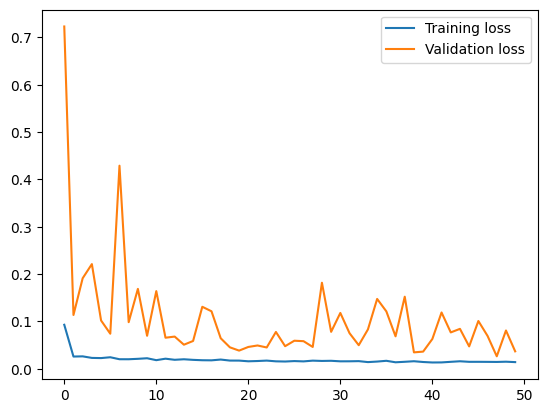

In [88]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [89]:
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)


[Timestamp('2020-05-01 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-04 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-05 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-06 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-07 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-08 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-11 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-12 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-13 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-14 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-15 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-18 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-19 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-20 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2020-05-21 00:00:00+0000', tz='UTC', freq='C')]


In [90]:
trainX.shape


(1244, 14, 5)

In [91]:

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction




1/1 [==============================] - 1s 989ms/step


In [92]:
prediction

array([[2.0438154],
       [2.105203 ],
       [2.1605241],
       [2.2247717],
       [2.2926204],
       [2.353237 ],
       [2.4194775],
       [2.4641697],
       [2.4138744],
       [2.4001043],
       [2.3603594],
       [2.4499323],
       [2.4955547],
       [2.546715 ],
       [2.5775852]], dtype=float32)

In [93]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [94]:

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


C:\Users\Mukund Mishra\AppData\Local\Temp\ipykernel_9300\2717579589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


<AxesSubplot: ylabel='open'>

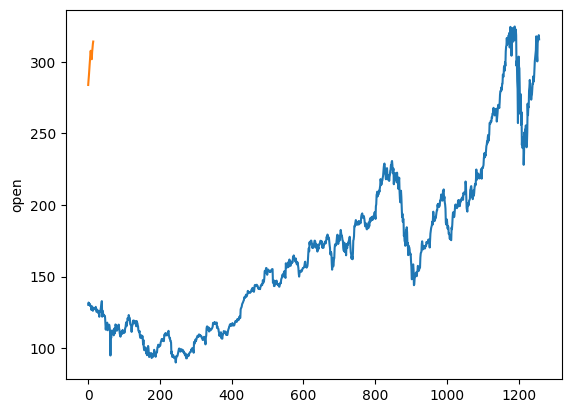

In [101]:

original = df[['date', 'open']]
original['date']=pd.to_datetime(original['date'])
# original = original.loc[original['date'] >= '2020-2-1']

sns.lineplot( original['open'])
sns.lineplot(df_forecast['Open'])

<AxesSubplot: ylabel='Open'>

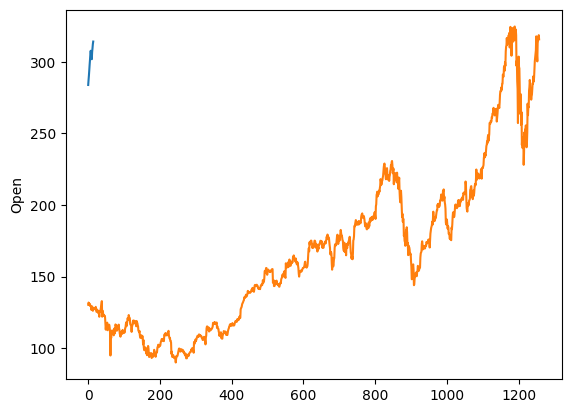

In [96]:
# original = original.loc[original['date']]
sns.lineplot(df_forecast['Open'])
sns.lineplot(original['open'])

